In [69]:
from collections import Counter
import pandas as pd
import re
import numpy
from os import listdir
from os.path import join, abspath
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [61]:
df = pd.read_csv("cnn_headlines.csv")
df.head()

,Unnamed: 0,Story,Highlights
0,0,new york mayoral candidate bill de blasio who ...,anthony weiners rollercoaster campaign comes t...
1,1,peppermint oil soluble fiber and antispasmodic...,an estimated to percent of people in north ame...
2,2,the eyes of the world are upon nelson mandela ...,makaziwe mandela all i pray for as a daughter ...
3,3,un secretarygeneral ban kimoon arrived friday ...,ban kimoon arrives to meet leaders survey dama...
4,4,a newlydiscovered work by spanish old master d...,previously unknown work by diego velazquez sel...


In [13]:
df=df.reset_index()
df['page'] = df.index

In [62]:
df.head()

,Unnamed: 0,Story,Highlights
0,0,new york mayoral candidate bill de blasio who ...,anthony weiners rollercoaster campaign comes t...
1,1,peppermint oil soluble fiber and antispasmodic...,an estimated to percent of people in north ame...
2,2,the eyes of the world are upon nelson mandela ...,makaziwe mandela all i pray for as a daughter ...
3,3,un secretarygeneral ban kimoon arrived friday ...,ban kimoon arrives to meet leaders survey dama...
4,4,a newlydiscovered work by spanish old master d...,previously unknown work by diego velazquez sel...


In [64]:
# A set of functions that operate on an array of document strings
from nltk.tokenize import word_tokenize

# Remove Stop Words
# Removes all stop words as they are defined in stopWords
# Returns array of documents s.t. there are no stop words
def removeStopWords(sentences, stopWords):
	resultSentences = []
	for idx, sentence in enumerate(sentences):
		tokens = word_tokenize(sentence)
		tokens = filter(lambda token: token not in stopWords, tokens)
		resultSentences.append(' '.join(tokens))
	return resultSentences


# Stem Sentences
# Applies the stemmer's stem method to all tokens
# Returns array of documents s.t. all terms are stems
def stemSentences(sentences, stemmer):
	stemmedSentences = []
	for idx, sentence in enumerate(sentences):
		tokens = word_tokenize(sentence)
		tokens = map(lambda token: stemmer.stem(token), tokens)
		stemmedSentences.append(' '.join(tokens))
	return stemmedSentences
	
	
# Remove Short Documents
# Returns array of documents greater than minLength
def removeShortDocs(sentences, minLength):
	return filter(lambda sentence: len(sentence) > minLength, sentences)

def scorer(cos_sim_matrix):
    largest = 0
    temp_idx = 0
    for idx, row in enumerate(cos_sim_matrix):
        adder = 0
        for col in row:
            adder += col
        #print(adder)
        if adder > largest:
            larger = largest
            largest = adder
            larger_idx = temp_idx
            largest_idx = idx
            temp_idx = idx
    return larger, largest, larger_idx, largest_idx


In [68]:
ps = PorterStemmer()
nltk_stop_words = set(stopwords.words('english'))
cluster_count = 3
vectorizer = TfidfVectorizer()
kMeansCluster = KMeans(n_clusters=cluster_count, random_state=10)

def summary_maker(raw_data):
    # split document into sentences and strip whitespace (delimeted by line)
    sentences = raw_data.split('.')
    sentences = map(lambda sentence: sentence.strip(), sentences)
    sentences = list(sentences)

    min_sentence_length = 30

    # remove sentences that do not contribute meaning by assuming short sentences have less meaning
    sentences = removeShortDocs(sentences, min_sentence_length)
    sentences = list(sentences)
    processedSentences = removeStopWords(sentences, nltk_stop_words)
    sentences = list(sentences)
    processedSentences = stemSentences(sentences, ps)
    tfidf_matrix = vectorizer.fit_transform(processedSentences)
    kMeansCluster.fit(tfidf_matrix)
    clusters = kMeansCluster.labels_.tolist()

    sentenceDictionary = {}
    for idx, sentence in enumerate(sentences):
        sentenceDictionary[idx] = {}
        sentenceDictionary[idx]['text'] = sentence
        sentenceDictionary[idx]['cluster'] = clusters[idx]
        sentenceDictionary[idx]['stemmed'] = processedSentences[idx]

    clusterDictionary = {}
    for key, sentence in sentenceDictionary.items():
        if sentence['cluster'] not in clusterDictionary:
            clusterDictionary[sentence['cluster']] = []
        clusterDictionary[sentence['cluster']].append(sentence['stemmed'])
        sentence['idx'] = len(clusterDictionary[sentence['cluster']]) - 1

    sorting_cluster = sorted(clusterDictionary.items(), key=lambda kv: (len(kv[1]), kv[0]), reverse=True)
    cluster_dictionary = {}
    for ids, sentences_list in sorting_cluster:
        cluster_dictionary[ids] = sentences_list
    
    remove_cluster = list(clusterDictionary.keys()) [3:]
    for ids in remove_cluster:    
        clusterDictionary.pop(ids)
    
    maxCosineScores = {}
    for key, clusterSentences in clusterDictionary.items():
        maxCosineScores[key] = {}
        maxCosineScores[key]['score'] = 0
        tfidf_matrix = vectorizer.fit_transform(clusterSentences)
        cos_sim_matrix = cosine_similarity(tfidf_matrix)
        
        larger, largest, larger_idx, largest_idx = scorer(cos_sim_matrix)
        maxCosineScores[key]['score'] = [largest, larger]
        maxCosineScores[key]['idx'] = [largest_idx, larger_idx]
        
#         for idx, row in enumerate(cos_sim_matrix):
#             sum = 0
#             for col in row:
#                 sum += col
#             if sum > maxCosineScores[key]['score']:
#                 maxCosineScores[key]['score'] = sum
#                 maxCosineScores[key]['idx'] = idx

#     resultIndices = []
#     for key, value in maxCosineScores.items():
#         cluster = key
#         idx = value['idx']
#         for key, value in sentenceDictionary.items():
#             if value['cluster'] == cluster and value['idx'] == idx:
#                 resultIndices.append(key)
#     resultIndices.sort()


    resultIndices = []
    i = 0
    for k, v in maxCosineScores.items():
        cluster = k
        for items in v['idx']:
            idx = items
            for key, value in sentenceDictionary.items():
                if value['cluster'] == cluster and value['idx'] == idx:
                    resultIndices.append(key)    
    resultIndices.sort()
    return resultIndices, sentences

In [70]:
collector = []
for rows, col in df.iterrows():
    resultIndices, sentences = summary_maker(col['Story'])
    result = ''
    for idx in resultIndices:
        result += sentences[idx] + '。'

    freq_dict = Counter(col['Story'].split())

    weight = []
    index = 0
    for lines in result.split('。'):
        if lines:
            adder = 0
            for word in lines.split():
                adder += freq_dict[word]
            weight.append([lines, adder, index])
        index +=1

    three_lines = sorted(weight, key=lambda x: x[1], reverse=True)[:3]

    adder = ''
    for sent, freq, index in sorted(three_lines, key=lambda x: x[2]):
        adder += sent + '. '
        
    collector.append(adder)


In [71]:
df['Summary'] = collector

In [72]:
df.head()

,Unnamed: 0,Story,Highlights,Summary
0,0,new york mayoral candidate bill de blasio who ...,anthony weiners rollercoaster campaign comes t...,new york mayoral candidate bill de blasio who ...
1,1,peppermint oil soluble fiber and antispasmodic...,an estimated to percent of people in north ame...,newer and more expensive medications have been...
2,2,the eyes of the world are upon nelson mandela ...,makaziwe mandela all i pray for as a daughter ...,the eyes of the world are upon nelson mandela ...
3,3,un secretarygeneral ban kimoon arrived friday ...,ban kimoon arrives to meet leaders survey dama...,im here to express the solidarity of the unite...
4,4,a newlydiscovered work by spanish old master d...,previously unknown work by diego velazquez sel...,a newlydiscovered work by spanish old master d...


In [168]:
df.to_csv('result_summary.csv')

In [81]:
import sys  
sys.path.insert(0, '/home/iftekhar/AI-system/SummarizationModels/PyRouge/PyRouge/')


In [83]:
from pyrouge import Rouge

In [84]:
r = Rouge()

system_generated_summary = "The Kyrgyz President pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections In an effort to live up to its reputation in the 1990s as an island of democracy. The use of ink is one part of a general effort to show commitment towards more open elections. improper use of this type of ink can cause additional problems as the elections in Afghanistan showed. The use of ink and readers by itself is not a panacea for election ills."

manual_summmary = "The use of invisible ink and ultraviolet readers in the elections of the Kyrgyz Republic which is a small, mountainous state of the former Soviet republic, causing both worries and guarded optimism among different sectors of the population. Though the actual technology behind the ink is not complicated, the presence of ultraviolet light (of the kind used to verify money) causes the ink to glow with a neon yellow light. But, this use of the new technology has caused a lot of problems. "

[precision, recall, f_score] = r.rouge_l([system_generated_summary], [manual_summmary])

print("Precision is :"+str(precision)+"\nRecall is :"+str(recall)+"\nF Score is :"+str(f_score))


Precision is :0.4460580912863071
Recall is :0.4396728016359918
F Score is :0.44284338048664124


In [128]:
collector = [] 
for index, col in df.iterrows():
    manual_summary = col['Highlights']
    system_generated_summary = col['Summary']
    [precision, recall, f_score] = r.rouge_l([system_generated_summary], [manual_summmary])
    # print("Precision is :"+str(precision)+", Recall is :"+str(recall)+", F Score is :"+str(f_score))
    collector.append([precision, recall, f_score])

In [129]:
score = pd.DataFrame(collector, columns = ['precision', 'recall', 'f_score'])

In [130]:
score.head()

,precision,recall,f_score
0,0.365127,0.501022,0.422415
1,0.378295,0.498978,0.430336
2,0.544586,0.349693,0.425904
3,0.354651,0.498978,0.414614
4,0.498542,0.349693,0.411059


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline


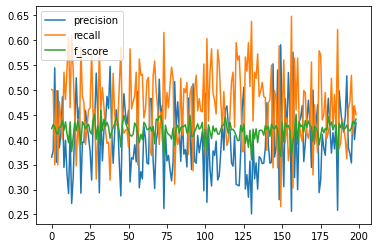

In [132]:
score.plot()
plt.show()

In [91]:
from rouge_score import rouge_scorer

sco = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
#scores = scorer.score('The quick brown fox jumps over the lazy dog',
#                       'The quick brown dog jumps on the log.')


In [154]:
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [93]:
collector2 = [] 
for index, col in df.iterrows():
    scores = sco.score(col['Highlights'], col['Summary'])
    precision = (scores['rouge1'][0] + scores['rougeL'][0])/2
    recall = (scores['rouge1'][1] + scores['rougeL'][1])/2
    f_score = (scores['rouge1'][2] + scores['rougeL'][2])/2
#     precision = (scores['rouge1'][0] )
#     recall = (scores['rouge1'][1] )
#     f_score = (scores['rouge1'][2] )
    
    collector2.append([precision, recall, f_score])

In [94]:
score_2 = pd.DataFrame(collector2, columns = ['precision', 'recall', 'f_score'])

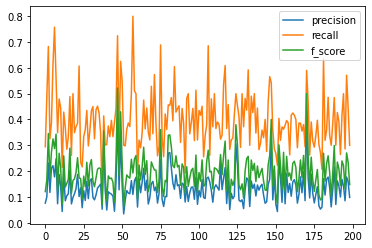

In [95]:
score_2.plot()

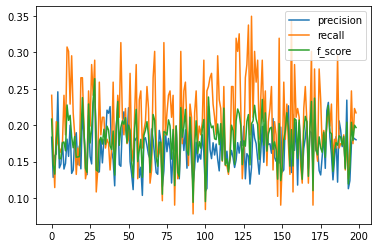

In [166]:
score_2.plot()

In [8]:
import sys
sys.path.append('/home/iftekhar/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg')


In [9]:
sys.path

['~/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg/pythonrouge',
 '/usr/local/spark/python',
 '/usr/local/spark/python/lib/py4j-0.10.8.1-src.zip',
 '/home/iftekhar/AI-system/SummarizationModels',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/iftekhar/amiebot/experiment_env/lib/python3.6/site-packages',
 '/home/iftekhar/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg',
 '/home/iftekhar/amiebot/experiment_env/lib/python3.6/site-packages/IPython/extensions',
 '/home/iftekhar/.ipython',
 '~/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg/pythonrouge',
 '~/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg/pythonrouge',
 '/home/iftekhar/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg/pythonrouge',
 '/home/iftekhar/amiebot/experiment_env/lib/python3.6/site-packages/pythonrouge-0.2-py3.6.egg']

In [15]:
from pythonrouge.pythonrouge import Pythonrouge

In [54]:
# system summary(predict) & reference summary
summary = [["Eiffel Tower of paris was the tallest man-made structure in the world until the Chrysler Building in New York City was finished in 1930. The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building. Its base is square. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building of paris. "]]
reference = [[["The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building. Its base is square, measuring 125 metres (410 ft) on each side. It is the second tallest free-standing structure in France after the Millau Viaduct."]]]

# initialize setting of ROUGE to eval ROUGE-1, 2, SU4
# if you evaluate ROUGE by sentence list as above, set summary_file_exist=False
# if recall_only=True, you can get recall scores of ROUGE
rouge = Pythonrouge(summary_file_exist=False,
                    summary=summary, reference=reference,
                    n_gram=3, ROUGE_SU4=True, ROUGE_L=True,
                    recall_only=True, stemming=True, stopwords=True,
                    word_level=True, length_limit=True, length=50,
                    use_cf=False, cf=95, scoring_formula='average',
                    resampling=True, samples=1000, favor=True, p=0.5)
score = rouge.calc_score()
print(score)

{'ROUGE-1': 0.57692, 'ROUGE-2': 0.48, 'ROUGE-3': 0.45833, 'ROUGE-L': 0.5, 'ROUGE-SU4': 0.47143}


In [33]:
score['ROUGE-1']

1.0

In [27]:
df = pd.read_csv('result_summary.csv')

In [29]:
df.head()

,Unnamed: 0,index,Unnamed: 0.1,Story,Highlights,page,Summary
0,0,0,0,new york mayoral candidate bill de blasio who ...,anthony weiners rollercoaster campaign comes t...,0,early wednesday the new york city board of ele...
1,1,1,1,peppermint oil soluble fiber and antispasmodic...,an estimated to percent of people in north ame...,1,it wasnt appreciated how much of an impact ibs...
2,2,2,2,the eyes of the world are upon nelson mandela ...,makaziwe mandela all i pray for as a daughter ...,2,she said her father was at peace and the famil...
3,3,3,3,un secretarygeneral ban kimoon arrived friday ...,ban kimoon arrives to meet leaders survey dama...,3,un secretarygeneral ban kimoon arrived friday ...
4,4,4,4,a newlydiscovered work by spanish old master d...,previously unknown work by diego velazquez sel...,4,a newlydiscovered work by spanish old master d...


In [73]:
collector = [] 
for index, col in df.iterrows():
    manual_summary = col['Highlights']
    system_generated_summary = col['Summary']
    summary = [[system_generated_summary]]
    reference = [[[manual_summary]]]
    rouge = Pythonrouge(summary_file_exist=False,
                    summary=summary, reference=reference,
                    n_gram=3, ROUGE_SU4=True, ROUGE_L=True,
                    recall_only=True, stemming=True, stopwords=True,
                    word_level=True, length_limit=True, length=50,
                    use_cf=False, cf=95, scoring_formula='average',
                    resampling=True, samples=1000, favor=True, p=0.5)
    score = rouge.calc_score()
    collector.append([score['ROUGE-1'], score['ROUGE-2'], 
                      score['ROUGE-3'], score['ROUGE-L'], score['ROUGE-SU4']])

In [74]:
score_3 = pd.DataFrame(collector, columns=['ROUGE-1', 'ROUGE-2', 'ROUGE-3', 'ROUGE-L', 'ROUGE-SU4'])
score_3.head()

,ROUGE-1,ROUGE-2,ROUGE-3,ROUGE-L,ROUGE-SU4
0,0.32000,0.08333,0.04348,0.16000,0.08209
1,0.09524,0.00000,0.00000,0.09524,0.02727
2,0.31250,0.06667,0.00000,0.18750,0.07500
3,0.06897,0.00000,0.00000,0.06897,0.01266
4,0.27586,0.14286,0.07407,0.27586,0.13924


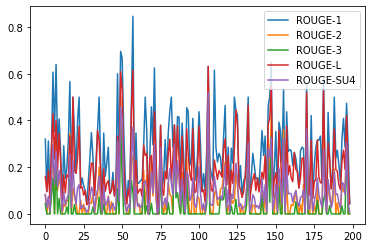

In [75]:
plt.Figure(figsize=(12,12))
score_3.plot()
plt.show()

In [77]:
from scipy.signal import savgol_filter

alldata_smoothed = score_3.apply(lambda x: savgol_filter(x,31,1))


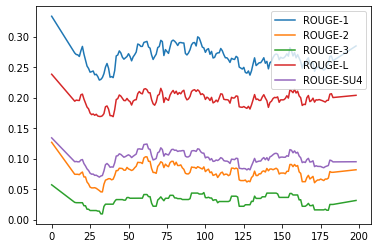

In [78]:
alldata_smoothed.plot()

In [56]:
alldata_smoothed.to_csv('performance_clustering_pict_cluster_topic_1.csv')

In [79]:
pre = pd.read_csv('performance_clustering_pict_cluster_topic_1.csv')

In [84]:
pre = pre.drop(columns=['Unnamed: 0'])

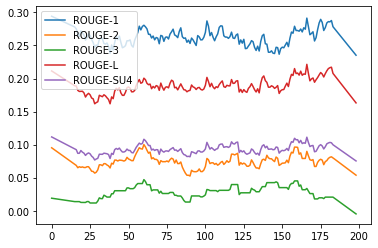

In [85]:
pre.plot()

https://github.com/nlpyang/BertSum  To compare

Models	 ROUGE-1	 ROUGE-2	ROUGE-L
Transformer Baseline	40.9	18.02	37.17
BERTSUM+Classifier	43.23	20.22	39.60
BERTSUM+Transformer	43.25	20.24	39.63
BERTSUM+LSTM	43.22	20.17	39.59